### Setup

In [1]:
cd ..

/Users/shimash/UNET


In [2]:
import sys
import traceback
import os
import pydoc
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from datetime import datetime
from utils.config import process_config
from utils.args import get_args
from utils.file import make_unique_path
import matplotlib.pylab as plt
from sklearn import metrics

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


In [3]:
config_file = "configs/simple_train.json"
checkpoint = "experiments/final.h5"

### Load Model & Data

In [4]:
config = process_config(config_file)

# make tensorflow quiet
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("> Create the data generator")
data_loader = pydoc.locate("data_loader." + config.data_loader.name)(
    config.data_loader
)

print("> Create the model")
config.model.args.num_classes = config.data_loader.base_args.num_classes
model = pydoc.locate("models." + config.model.name)(**config.model.args)

> Create the data generator
> Create the model


In [5]:
model.load_weights(checkpoint)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Plot validation data

In [7]:
val_flow = data_loader.val

In [15]:
X, y = val_flow[2]
pred = model.predict(X)

In [12]:
labels = np.arange(0, 1)
pred_map = np.argmax(pred, axis=-1)[..., np.newaxis] == labels

In [13]:
idx = 0

TypeError: Invalid shape (256, 256, 1) for image data

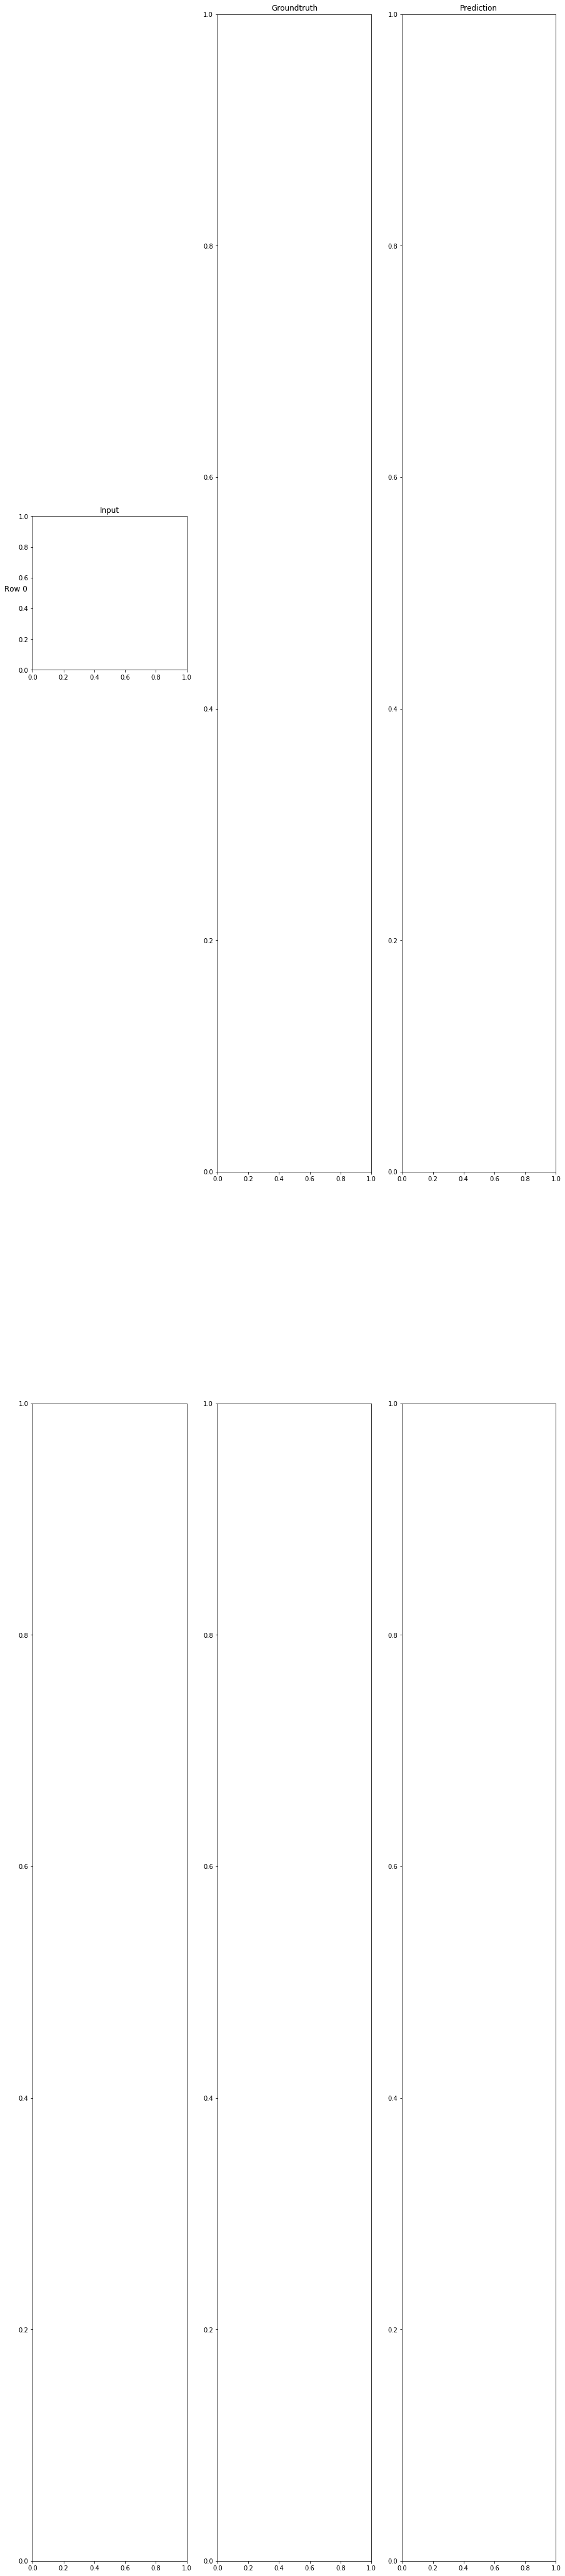

In [14]:
cols = ["Input", "Groundtruth", "Prediction"]
rows = ['Row {}'.format(row) for row in range(1)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 75))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
    
for i, ax in enumerate(axes):
    ax[0].imshow(X[idx])
    ax[1].imshow(y[idx,...,i])
    ax[2].imshow(pred_map[idx,...,i])
    
    for i in range(3):
        ax[i].axis("off")

fig.tight_layout()
plt.show()

### IoU calculation & Confusion matrix

In [28]:
class_labels = [
    "Background",
    "Hat",
    "Hair",
    "Glove",
    "Sunglasses",
    "UpperClothes",
    "Dress",
    "Coat",
    "Socks",
    "Pants",
    "Torso-skin",
    "Scarf",
    "Skirt",
    "Face",
    "Left-arm",
    "Right-arm",
    "Left-leg",
    "Right-leg",
    "Left-shoe",
    "Right-shoe",
]

In [46]:
val_flow = data_loader.val

In [62]:
batch_id = 1249

In [91]:
X, y = val_flow[batch_id]
pred = model.predict(X)

In [92]:
# convert back to sparse-one-hot
y_true_batch = np.argmax(y, axis=-1)
y_pred_batch = np.argmax(pred, axis=-1)

In [93]:
# use first image in batch & flatten matrix to 1d array
y_true = y_true_batch[0].flatten()
y_pred = y_pred_batch[0].flatten()

In [94]:
m_iou = 0
for i, label in enumerate(class_labels):
    y_true_class = y_true == i
    y_pred_class = y_pred == i
    iou = metrics.jaccard_score(y_true_class, y_pred_class, average="binary")
    m_iou += iou
    print("{:.5s}:\t {:.3f}".format(label, iou))
print(m_iou/10)

Backg:	 0.891
Hat:	 0.519
Hair:	 0.248
Glove:	 0.000
Sungl:	 0.000
Upper:	 0.000
Dress:	 0.000
Coat:	 0.665
Socks:	 0.000
Pants:	 0.000
Torso:	 0.858
Scarf:	 0.000
Skirt:	 0.000
Face:	 0.889
Left-:	 0.883
Right:	 0.681
Left-:	 0.000
Right:	 0.000
Left-:	 0.000
Right:	 0.000
0.5632546499574302


In [95]:
def plot_confusion_matrix(y_true, y_pred, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None,
                          cmap='viridis', ax=None):
    """Plot Confusion Matrix.
    Read more in the :ref:`User Guide <confusion_matrix>`.
    Parameters
    ----------
    labels : array-like of shape (n_classes,), default=None
        List of labels to index the matrix. This may be used to reorder or
        select a subset of labels. If `None` is given, those that appear at
        least once in `y_true` or `y_pred` are used in sorted order.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    normalize : {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.
    display_labels : array-like of shape (n_classes,), default=None
        Target names used for plotting. By default, `labels` will be used if
        it is defined, otherwise the unique labels of `y_true` and `y_pred`
        will be used.
    include_values : bool, default=True
        Includes values in confusion matrix.
    xticks_rotation : {'vertical', 'horizontal'} or float, \
                        default='vertical'
        Rotation of xtick labels.
    values_format : str, default=None
        Format specification for values in confusion matrix. If `None`,
        the format specification is '.2f' for a normalized matrix, and
        'd' for a unnormalized matrix.
    cmap : str or matplotlib Colormap, default='viridis'
        Colormap recognized by matplotlib.
    ax : matplotlib Axes, default=None
        Axes object to plot on. If `None`, a new figure and axes is
        created.
    Returns
    -------
    display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
    """

    cm = metrics.confusion_matrix(y_true, y_pred, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = estimator.classes_
        else:
            display_labels = labels

    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)

TypeError: confusion_matrix() got an unexpected keyword argument 'normalize'

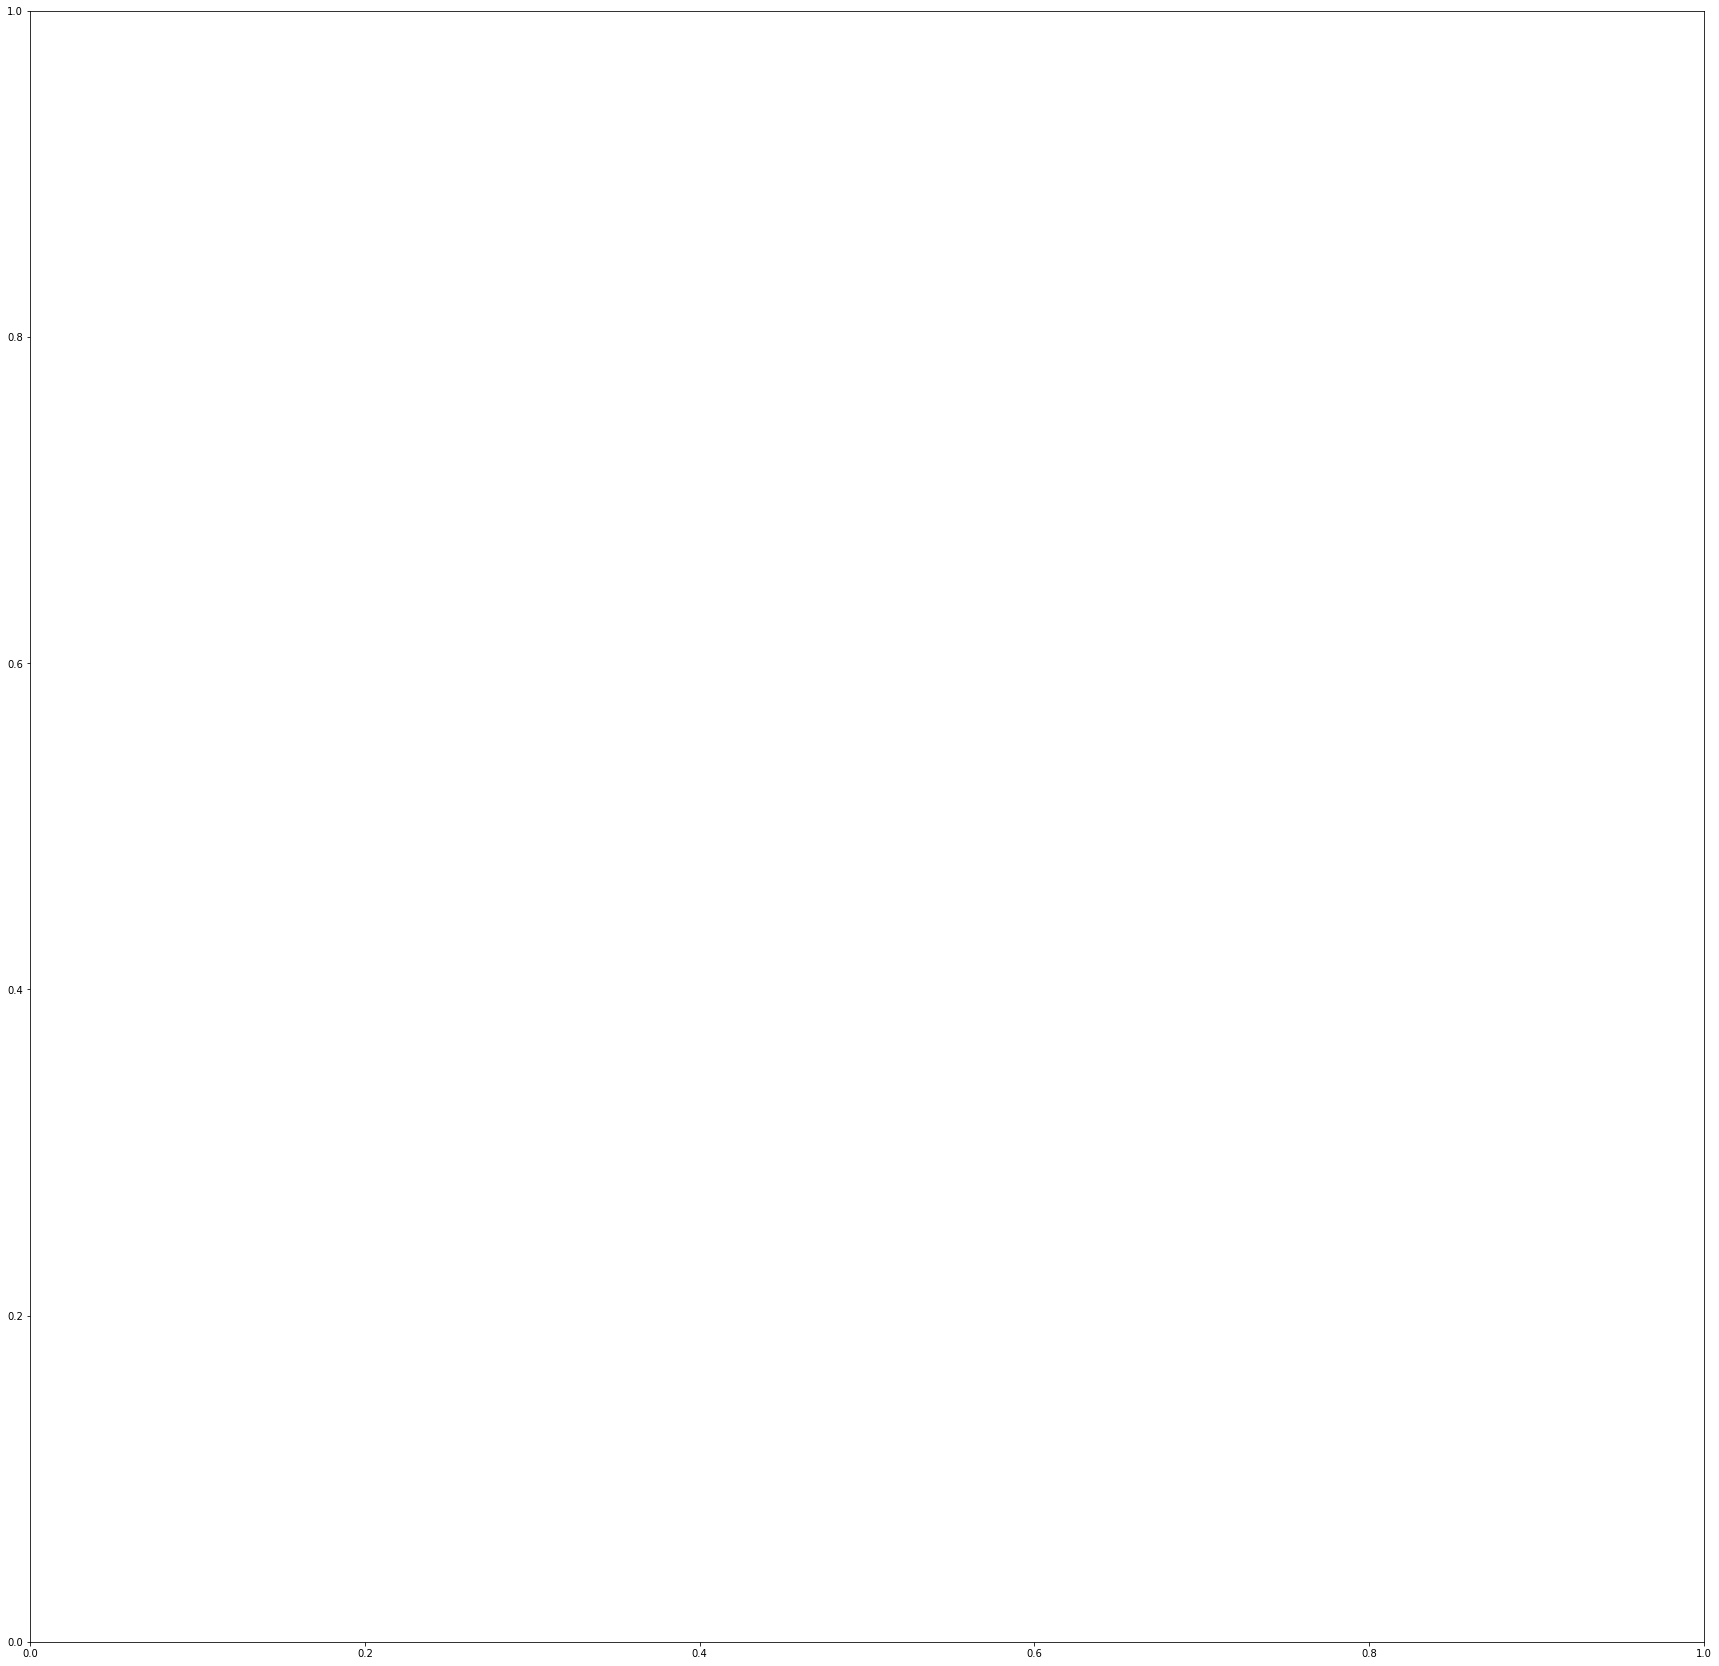

In [99]:
fig, ax = plt.subplots(figsize=(30,30))
np.set_printoptions(precision=2)
plot_confusion_matrix(y_true, y_pred, display_labels=class_labels, ax=ax, cmap="Blues")
plt.title("Confusion matrix, without normalization")

TypeError: confusion_matrix() got an unexpected keyword argument 'normalize'

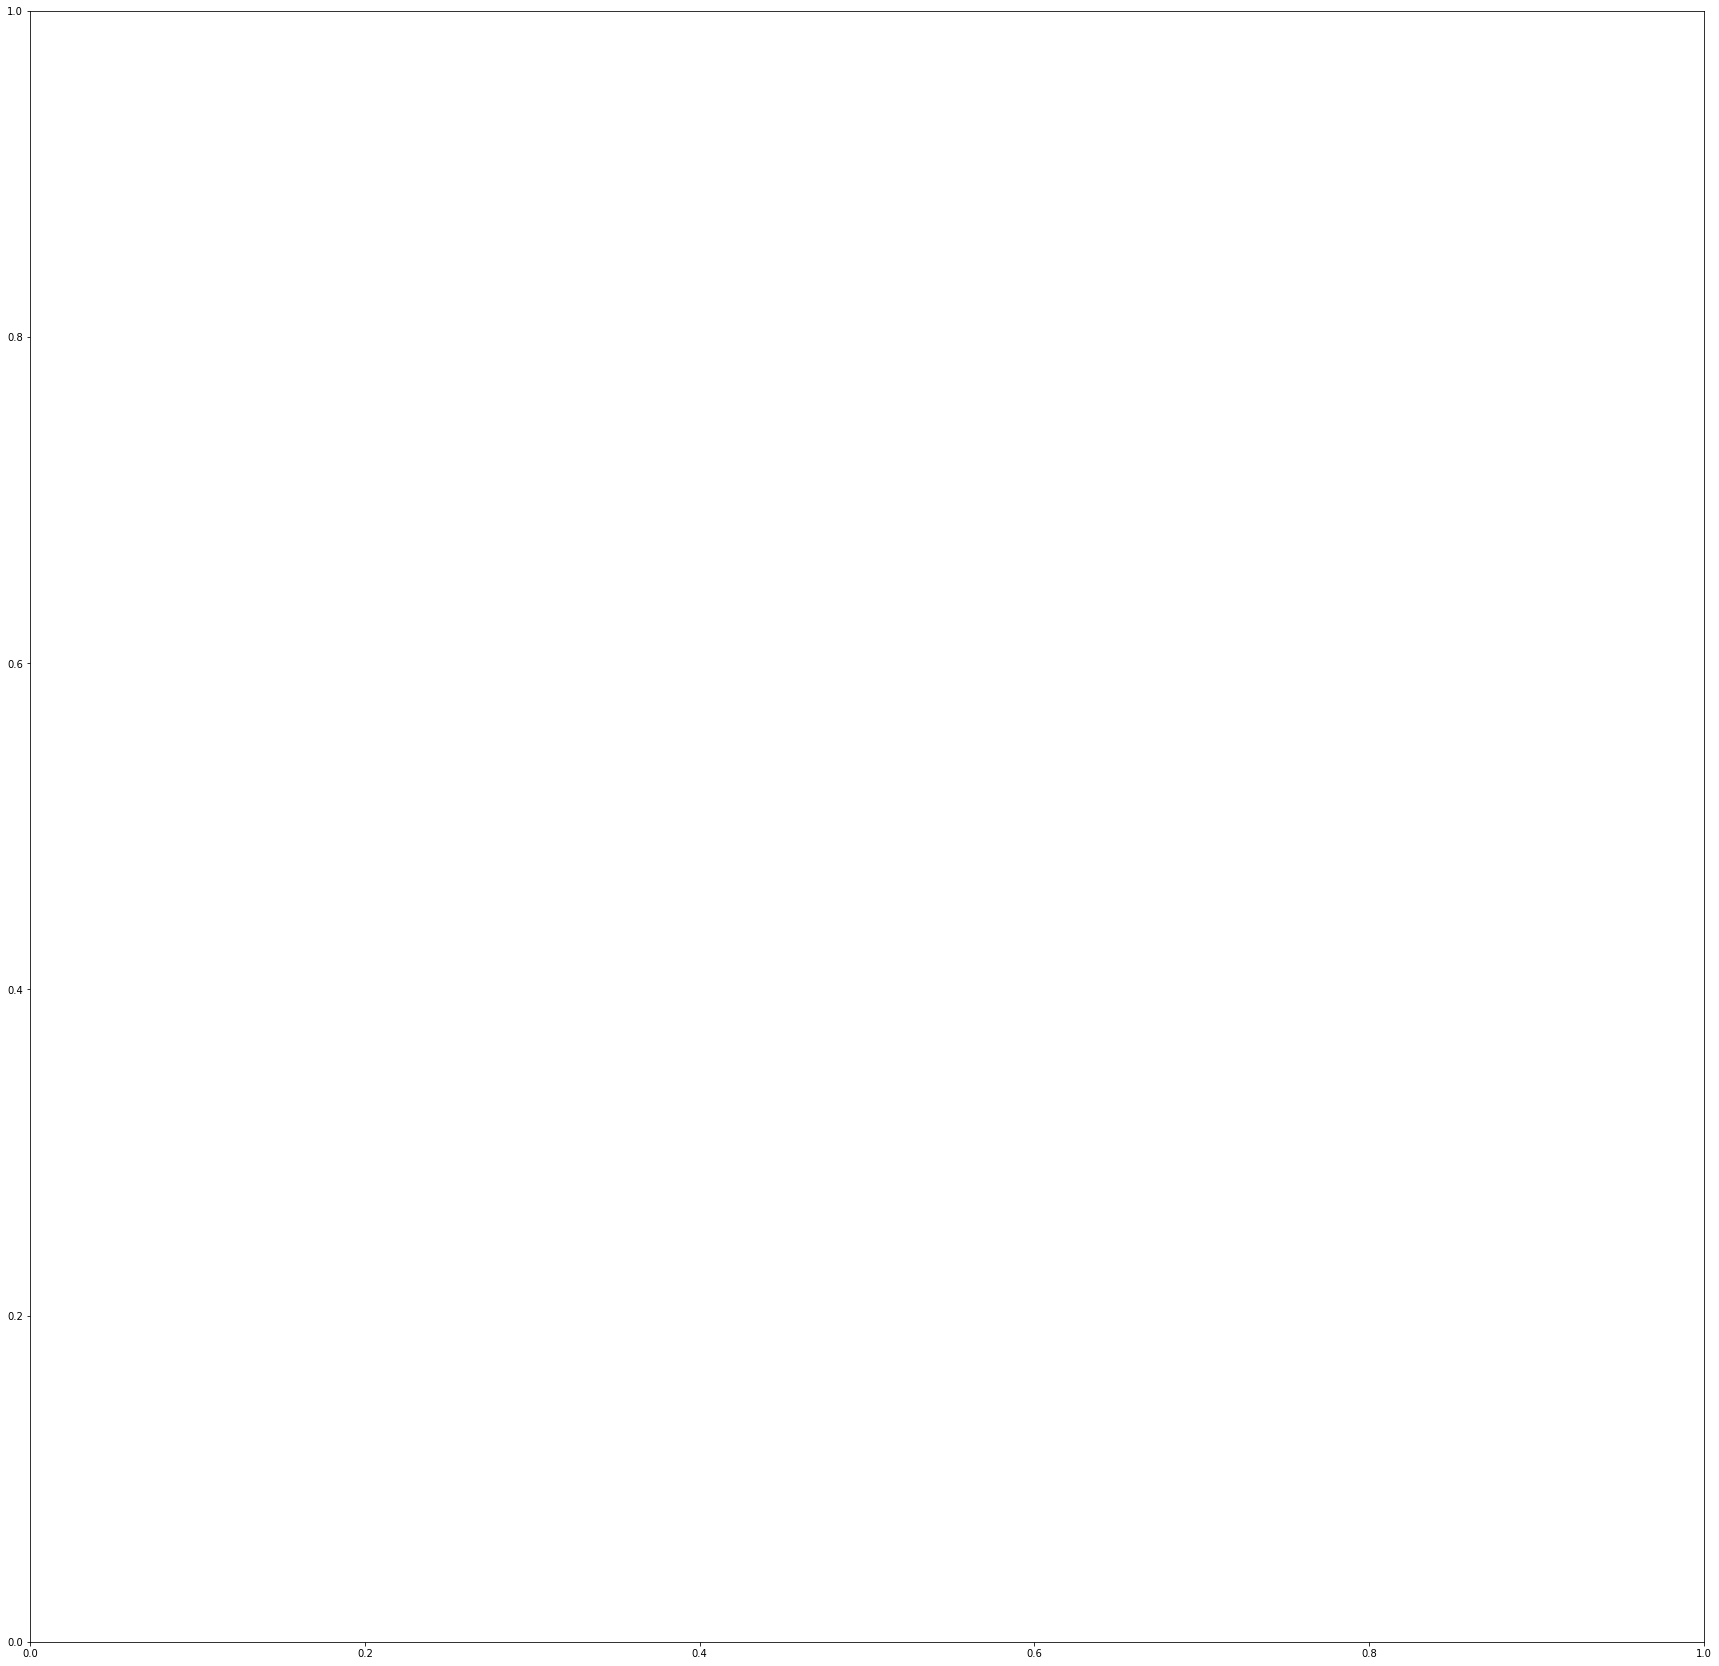

In [98]:
fig, ax = plt.subplots(figsize=(30,30))
np.set_printoptions(precision=2)
plot_confusion_matrix(y_true, y_pred, normalize="true", display_labels=class_labels, ax=ax, cmap="Blues")
plt.title("Confusion matrix, with normalization")